<a href="https://colab.research.google.com/github/eduardoplima/rl-imd/blob/main/relatorio_aprendizado_reforco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizado por Reforço - Avaliação Final


O aprendizado por reforço é uma subárea da inteligência artificial que busca treinar agentes para tomar decisões em ambientes interativos com o objetivo de maximizar uma recompensa acumulada ao longo do tempo. Diferente de métodos supervisionados, onde há dados rotulados para guiar o aprendizado, no aprendizado por reforço o agente explora o ambiente por meio de tentativa e erro, ajustando suas ações com base no feedback recebido na forma de recompensas ou penalidades. Esse processo ocorre em um ciclo contínuo de interação, no qual o agente observa o estado do ambiente, toma uma ação, recebe uma recompensa e atualiza sua estratégia, aprendendo gradualmente a executar comportamentos que levam a melhores resultados.

Dentre os algoritmos mais conhecidos de aprendizado por reforço estão o SARSA e o Q-Learning, que utilizam a chamada tabela Q para armazenar e atualizar os valores associados a pares de estado e ação. O SARSA (State-Action-Reward-State-Action) é um algoritmo on-policy, o que significa que ele atualiza os valores Q com base na política atual, considerando a sequência de ações efetivamente escolhidas pelo agente. Já o Q-Learning é um método off-policy, onde a atualização dos valores Q se baseia na ação com maior recompensa esperada, independentemente da política seguida no momento. Enquanto o SARSA tende a ser mais conservador e adequado para cenários com riscos elevados, o Q-Learning é mais exploratório e busca estratégias otimizadas globalmente, sendo amplamente utilizado em diversas aplicações, como jogos, controle de sistemas e robótica.

Nesse notebook estão exemplos de aplicações com ambas as técnicas na biblioteca python Gymnasium. Os ambientes explorados são o `Frozen Lake`, onde o agente precisa alcançar um objetivo sem cair em buracos em um ambiente baseado em grade, e o `Cart Pole`, cujo objetivo é balancear um pêndulo invertido sobre um carrinho movendo-o para a esquerda ou direita.

## `Frozen Lake`

No `Frozen Lake`, o objetivo é atravessar um lago congelado do ponto S ao objetivo G sem cair em qualquer buraco H ao longo dos espaço F do território. Se a natureza do ambiente for escorregadia (`slippery`), o agente pode tomar direções não calculadas.

O agente recebe 1 vetor para suas ações. O espaço de ação é definido por `(dir)`, que define a direção a seguir a partir das opções:

* 0: ESQUERDA
* 1: ABAIXO
* 2: DIREITA
* 3: ACIMA

A observação é um valor que represente a posição atual do agente e é definido por `current_row * nrows + current_col`, ou seja, a linha atual vezes a quantidade de linhas mais a coluna atual.

As recompensas são definidas como:

* Objetivo(G): +1
* Buraco(H): 0
* Congelado(F): 0

### Configuração do ambiente

In [1]:
%%capture
!pip install gymnasium
!pip install numpy
!pip install imageio imageio_ffmpeg
!pip install pyvirtualdisplay
!apt-get install -y xvfb
!apt-get install -y python-opengl ffmpeg
!pip install pytorch

In [2]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:

from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [4]:
from gym.envs.toy_text.frozen_lake import generate_random_map

# Criação e inspeção do ambiente Frozen Lake.
side_map_size = 8
proba_frozen = 0.9

env = gym.make('FrozenLake-v1', is_slippery=False, render_mode="rgb_array", desc=generate_random_map(size=side_map_size, p=proba_frozen))
env.spec

EnvSpec(id='FrozenLake-v1', entry_point='gymnasium.envs.toy_text.frozen_lake:FrozenLakeEnv', reward_threshold=0.7, nondeterministic=False, max_episode_steps=100, order_enforce=True, disable_env_checker=False, kwargs={'map_name': '4x4', 'is_slippery': False, 'render_mode': 'rgb_array', 'desc': ['SFFFFFFF', 'FFFFFFFH', 'FFFFFFFF', 'HFHFFFFF', 'FFFFHFFF', 'FFFHFFFF', 'FFFFFHFF', 'FFFFFHFG']}, namespace=None, name='FrozenLake', version=1, additional_wrappers=(), vector_entry_point=None)

In [5]:
actions = ["move left", "move down", "move right", "move up"]
print ("Actions:", actions)

Actions: ['move left', 'move down', 'move right', 'move up']


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
def plot_image(plot, render, size):
  plot.figure(figsize=(14, 5))
  plot.xticks(range(size))
  plot.yticks(range(size))
  plot.imshow(render, extent=[0, size, size, 0])
  plot.show()

/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

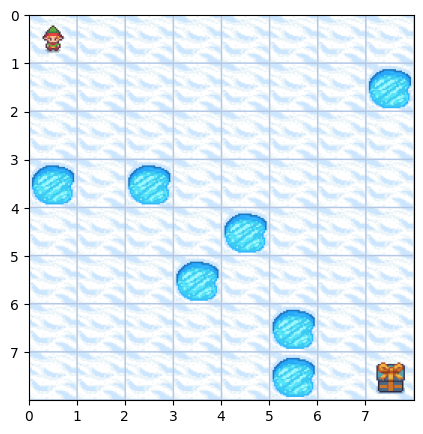

In [7]:
# This sets the initial state at S, our starting point
# We can render the environment to see where we are on the frozenlake gridworld
env.reset()
img = env.render()
plot_image(plt,img,int(np.sqrt(env.observation_space.n)))

Executamos ações aleatórias para testar o ambiente

In [8]:
print("passo número : ação, posição, recompensa, terminado, truncado, {info}")

for i in range(20):
    # Amostra aleatória de ação válida
    action = env.action_space.sample()

    state, reward, terminated, truncated, info = env.step(action)
    is_terminal = terminated or truncated

    print("passo", i+1, ":", action, ",", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
    if(is_terminal):
        break

passo número : ação, posição, recompensa, terminado, truncado, {info}
passo 1 : 3 , move up , 0 , 0.0 , False , False , {'prob': 1.0}
passo 2 : 3 , move up , 0 , 0.0 , False , False , {'prob': 1.0}
passo 3 : 1 , move down , 8 , 0.0 , False , False , {'prob': 1.0}
passo 4 : 1 , move down , 16 , 0.0 , False , False , {'prob': 1.0}
passo 5 : 0 , move left , 16 , 0.0 , False , False , {'prob': 1.0}
passo 6 : 2 , move right , 17 , 0.0 , False , False , {'prob': 1.0}
passo 7 : 1 , move down , 25 , 0.0 , False , False , {'prob': 1.0}
passo 8 : 0 , move left , 24 , 0.0 , True , False , {'prob': 1.0}


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder
before_training = "before_training.mp4"
video = VideoRecorder(env, before_training)

state, info = env.reset()
env.render()
video.capture_frame()

for i in range(100):
    action = env.action_space.sample()

    state, reward, terminated, truncated, info = env.step(action)
    is_terminal = terminated or truncated

    env.render()
    video.capture_frame()

    if(is_terminal):
        print("step", i+1, ":", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
        break

video.close()

/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 9 : move down , 24 , 0.0 , True , False , {'prob': 1.0}


In [10]:
from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

from IPython.display import HTML
html = render_mp4(before_training)
HTML(html)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Criando uma estratégia SARSA ou Q-Learning tabular para o Frozen Lake

A classe a seguir

In [11]:
class FrozenLakeAgent:
    def __init__(
        self,
        alpha_learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        gamma_discount_factor: float,
        state_size: int,
        action_size: int,
        is_using_Sarsa: bool
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_table), a learning rate and an epsilon.

        Args:
            alpha_learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            gamma_discount_factor: The discount factor for computing the Q-value
            state_size: The state space
            action_size: The action space
            is_using_Sarsa: Sarsa or Q-learning method
        """
        self.alpha_learning_rate = alpha_learning_rate
        self.gamma_discount_factor = gamma_discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.state_size = state_size
        self.action_size = action_size
        self.is_using_Sarsa = is_using_Sarsa
        self.training_error = []
        self.q_table = np.zeros((self.state_size, self.action_size))

        if(self.is_using_Sarsa):
            print("Using Sarsa method")
        else:
            print("Using Q-learning method")

        # Set the seed
        self.rng = np.random.default_rng(100785)

    def get_Q_Table(self):
        return self.q_table

    def eval_state(self, state):
        # Break ties randomly
        # Find the indices where the Q-value equals the maximum value
        # Choose a random action from the indices where the Q-value is maximum
        max_ids = np.where(self.q_table[state, :] == np.max(self.q_table[state, :]))[0]
        return self.rng.choice(max_ids)

    def choose_action(self, state):
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # First we randomize a number
        exploration_exploitation_tradeoff = self.rng.uniform(0, 1)

        # Exploration
        # with probability epsilon return a random action to explore the environment
        if exploration_exploitation_tradeoff < self.epsilon:
            return env.action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return self.eval_state(state)

    def update(
        self,
        state: int,
        action: int,
        reward: float,
        terminated: bool,
        next_state: int,
        next_action: int
    ):
        """Updates the Q-value of an action."""
        if terminated:
            target = reward
        else:
            # Sarsa: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * Q(s',a') - Q(s,a)]
            if(self.is_using_Sarsa):
                target = reward + self.gamma_discount_factor * self.q_table[next_state, next_action]

            # Q-learning: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            else:
                target = reward + self.gamma_discount_factor * np.max(self.q_table[next_state, :])

        temporal_difference_error = target - self.q_table[state, action]

        # Train the agent using target and the predicted q_table values
        self.q_table[state, action] = self.q_table[state, action] + self.alpha_learning_rate * temporal_difference_error

        self.training_error.append(temporal_difference_error)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

In [12]:
# hyperparameters
alpha_learning_rate = 0.5 # @param {type:"number"}
nb_max_episodes = 10000 # @param {type:"integer"}
start_epsilon = 0.5 # @param {type:"number"}
final_epsilon = 0.1 # @param {type:"number"}
epsilon_decay = (start_epsilon - final_epsilon) / nb_max_episodes # reduce the exploration over time
gamma_discount_factor = 0.95 # @param {type:"number"}
is_using_Sarsa = False # @param {type:"boolean"}
test_freq = 100 # @param {type:"integer"}
total_steps = 0

agent_sarsa = FrozenLakeAgent(
    alpha_learning_rate=alpha_learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    gamma_discount_factor=gamma_discount_factor,
    state_size = env.observation_space.n,
    action_size = env.action_space.n,
    is_using_Sarsa = True
)

agent_q = FrozenLakeAgent(
    alpha_learning_rate=alpha_learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    gamma_discount_factor=gamma_discount_factor,
    state_size = env.observation_space.n,
    action_size = env.action_space.n,
    is_using_Sarsa = False
)


Using Sarsa method
Using Q-learning method


In [13]:
def test_accurracy(agent, num_steps, num_episodes=100):
    counter = 0
    nb_success = 0.0

    while counter < num_episodes:
        is_terminal = False
        state, info = env.reset()

        for i in range(num_steps):
            action = agent.eval_state(state)
            state, reward, terminated, truncated, info = env.step(action)
            is_terminal = terminated or truncated
            nb_success += reward

            if(is_terminal):
                break

        counter += 1

    return nb_success/counter

In [14]:
def record_trained_video(agent, video_file, num_steps):
    video = VideoRecorder(env, video_file)

    # returns an initial observation
    state, info = env.reset()
    env.render()
    video.capture_frame()

    for i in range(num_steps):
        action = agent.eval_state(state)
        state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        env.render()
        video.capture_frame()

        if(is_terminal):
            print("step", i+1, ":", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
            break

    video.close()

In [15]:
from tqdm import tqdm
def train_agent(agent, is_using_Sarsa):
  #Create lists to contain total rewards, steps and accurracy per episode
  accuracies = []
  mean_rewards = []
  rewards = []
  steps = []
  total_steps = 0

  for episode_count in tqdm(range(nb_max_episodes)):
      state, info = env.reset()
      is_terminal = False
      total_reward = 0
      episode_step = 0

      if(is_using_Sarsa): # Sarsa
          # Choose an action by greedily (with epsilon chance of random action) from the Q-Table
          action = agent.choose_action(state)

      # The Q-Table training
      while not is_terminal:
          episode_step += 1

          if(not is_using_Sarsa): # Q-learning
              # Choose an action by greedily (with epsilon chance of random action) from the Q-Table
              action = agent.choose_action(state)

          # Play best or random move and get new state and reward from environment
          next_state, reward, terminated, truncated, info = env.step(action)
          is_terminal = terminated or truncated

          # update the agent
          if(not is_using_Sarsa): # Q-learning
              agent.update(state, action, reward, terminated, next_state, None)
          else: # Sarsa
              next_action = agent.choose_action(next_state)
              agent.update(state, action, reward, terminated, next_state, next_action)
              action = next_action

          # update the current observation
          state = next_state
          total_steps += 1
          total_reward += reward

      agent.decay_epsilon()

      mean_rewards.append(total_reward)
      if (episode_count+1) % test_freq == 0:
          accur = test_accurracy(agent, env.spec.max_episode_steps,50)
          accuracies.append(accur)

          print('step: %s, episode: %s, accuracy training: %s, accuracy test: %s, random move probability: %s' % (total_steps, episode_count+1, sum(mean_rewards)/test_freq, accur, agent.epsilon))
          mean_rewards.clear()

      rewards.append(total_reward)
      steps.append(episode_step)

  after_training = "after_training_sarsa.mp4" if is_using_Sarsa else "after_training_q.mp4"
  record_trained_video(agent, after_training, env.spec.max_episode_steps)
  env.close()
  return after_training, rewards, steps, accuracies

In [16]:
after_training_sarsa, rewards_sarsa, steps_sarsa, accuracies_sarsa = train_agent(agent_sarsa, True)
html_sarsa = render_mp4(after_training_sarsa)
HTML(html_sarsa)


  1%|          | 91/10000 [00:00<00:22, 431.87it/s]

step: 2738, episode: 100, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.49600000000000155


  2%|▏         | 228/10000 [00:01<00:47, 205.87it/s]

step: 5297, episode: 200, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.4920000000000031


  3%|▎         | 341/10000 [00:01<00:45, 212.60it/s]

step: 7919, episode: 300, accuracy training: 0.0, accuracy test: 0.04, random move probability: 0.48800000000000465


  5%|▍         | 451/10000 [00:01<00:37, 253.62it/s]

step: 10245, episode: 400, accuracy training: 0.01, accuracy test: 0.0, random move probability: 0.4840000000000062


  6%|▌         | 577/10000 [00:02<00:30, 305.94it/s]

step: 12869, episode: 500, accuracy training: 0.01, accuracy test: 0.06, random move probability: 0.48000000000000775


  7%|▋         | 665/10000 [00:02<00:32, 285.61it/s]

step: 15494, episode: 600, accuracy training: 0.03, accuracy test: 0.06, random move probability: 0.4760000000000093


  7%|▋         | 728/10000 [00:03<00:58, 157.74it/s]

step: 18413, episode: 700, accuracy training: 0.53, accuracy test: 0.0, random move probability: 0.47200000000001086


  9%|▉         | 876/10000 [00:03<00:34, 263.10it/s]

step: 21208, episode: 800, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.4680000000000124


  9%|▉         | 941/10000 [00:04<00:34, 259.33it/s]

step: 23829, episode: 900, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.46400000000001396


 10%|█         | 1036/10000 [00:04<00:37, 242.02it/s]

step: 26295, episode: 1000, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.4600000000000155


 11%|█         | 1108/10000 [00:05<00:50, 177.61it/s]

step: 29048, episode: 1100, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.45600000000001706


 13%|█▎        | 1261/10000 [00:05<00:37, 232.93it/s]

step: 31695, episode: 1200, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.4520000000000186


 14%|█▎        | 1366/10000 [00:06<00:30, 287.09it/s]

step: 34339, episode: 1300, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.44800000000002016


 14%|█▍        | 1425/10000 [00:07<01:33, 92.02it/s] 

step: 36897, episode: 1400, accuracy training: 0.71, accuracy test: 0.0, random move probability: 0.4440000000000217


 15%|█▌        | 1538/10000 [00:08<01:11, 117.54it/s]

step: 39572, episode: 1500, accuracy training: 0.8, accuracy test: 0.0, random move probability: 0.44000000000002326


 17%|█▋        | 1663/10000 [00:08<00:38, 216.04it/s]

step: 42325, episode: 1600, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.4360000000000248


 17%|█▋        | 1718/10000 [00:08<00:51, 161.08it/s]

step: 44930, episode: 1700, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.43200000000002636


 18%|█▊        | 1825/10000 [00:10<01:35, 85.29it/s]

step: 47374, episode: 1800, accuracy training: 0.75, accuracy test: 0.0, random move probability: 0.4280000000000279


 19%|█▉        | 1923/10000 [00:10<00:56, 142.28it/s]

step: 49949, episode: 1900, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.42400000000002946


 20%|██        | 2036/10000 [00:11<00:52, 150.69it/s]

step: 52325, episode: 2000, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.420000000000031


 21%|██▏       | 2127/10000 [00:11<00:48, 163.74it/s]

step: 54725, episode: 2100, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.41600000000003257


 23%|██▎       | 2260/10000 [00:12<00:50, 153.52it/s]

step: 57322, episode: 2200, accuracy training: 0.77, accuracy test: 0.0, random move probability: 0.4120000000000341


 24%|██▎       | 2363/10000 [00:13<00:32, 237.63it/s]

step: 59716, episode: 2300, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.40800000000003567


 24%|██▍       | 2440/10000 [00:13<00:30, 251.40it/s]

step: 62230, episode: 2400, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.4040000000000372


 26%|██▌       | 2557/10000 [00:13<00:26, 276.32it/s]

step: 64736, episode: 2500, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.40000000000003877


 27%|██▋       | 2700/10000 [00:14<00:25, 290.22it/s]

step: 67212, episode: 2600, accuracy training: 0.79, accuracy test: 0.0, random move probability: 0.3960000000000403
step: 69652, episode: 2700, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.39200000000004187


 29%|██▉       | 2909/10000 [00:14<00:13, 506.57it/s]

step: 71996, episode: 2800, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.3880000000000434
step: 74325, episode: 2900, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.38400000000004497


 31%|███       | 3061/10000 [00:15<00:21, 324.44it/s]

step: 76651, episode: 3000, accuracy training: 0.8, accuracy test: 0.0, random move probability: 0.3800000000000465


 32%|███▏      | 3172/10000 [00:15<00:17, 385.70it/s]

step: 79001, episode: 3100, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.3760000000000481


 33%|███▎      | 3300/10000 [00:15<00:18, 356.45it/s]

step: 81260, episode: 3200, accuracy training: 0.91, accuracy test: 0.0, random move probability: 0.3720000000000496
step: 83717, episode: 3300, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.3680000000000512


 35%|███▌      | 3528/10000 [00:16<00:12, 536.49it/s]

step: 86000, episode: 3400, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.3640000000000527
step: 88337, episode: 3500, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.3600000000000543


 37%|███▋      | 3697/10000 [00:16<00:12, 499.44it/s]

step: 90664, episode: 3600, accuracy training: 0.85, accuracy test: 0.0, random move probability: 0.3560000000000558
step: 93086, episode: 3700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.3520000000000574


 39%|███▉      | 3907/10000 [00:16<00:09, 610.99it/s]

step: 95488, episode: 3800, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.34800000000005893
step: 97570, episode: 3900, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.3440000000000605


 41%|████      | 4072/10000 [00:17<00:08, 667.29it/s]

step: 99716, episode: 4000, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.34000000000006203
step: 102014, episode: 4100, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.3360000000000636


 43%|████▎     | 4296/10000 [00:17<00:10, 535.77it/s]

step: 104115, episode: 4200, accuracy training: 0.72, accuracy test: 0.0, random move probability: 0.33200000000006513
step: 106383, episode: 4300, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.3280000000000667


 45%|████▌     | 4501/10000 [00:17<00:08, 615.47it/s]

step: 108594, episode: 4400, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.32400000000006823
step: 110791, episode: 4500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.3200000000000698


 47%|████▋     | 4735/10000 [00:18<00:07, 678.65it/s]

step: 113221, episode: 4600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.31600000000007133
step: 115258, episode: 4700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.3120000000000729


 49%|████▉     | 4900/10000 [00:18<00:09, 533.06it/s]

step: 117379, episode: 4800, accuracy training: 0.9, accuracy test: 0.0, random move probability: 0.30800000000007444
step: 119529, episode: 4900, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.304000000000076


 51%|█████▏    | 5139/10000 [00:18<00:07, 645.95it/s]

step: 121660, episode: 5000, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.30000000000007754
step: 123793, episode: 5100, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.2960000000000791


 53%|█████▎    | 5300/10000 [00:19<00:07, 661.55it/s]

step: 125836, episode: 5200, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.29200000000008064
step: 127841, episode: 5300, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.2880000000000822


 55%|█████▍    | 5499/10000 [00:19<00:05, 781.54it/s]

step: 129899, episode: 5400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.28400000000008374
step: 131913, episode: 5500, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.2800000000000853


 57%|█████▋    | 5729/10000 [00:19<00:05, 719.77it/s]

step: 133953, episode: 5600, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.27600000000008684
step: 135915, episode: 5700, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.2720000000000884


 59%|█████▉    | 5900/10000 [00:20<00:07, 567.92it/s]

step: 138218, episode: 5800, accuracy training: 0.9, accuracy test: 0.0, random move probability: 0.26800000000008994
step: 140185, episode: 5900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.2640000000000915


 61%|██████▏   | 6145/10000 [00:20<00:07, 519.36it/s]

step: 142103, episode: 6000, accuracy training: 0.95, accuracy test: 0.0, random move probability: 0.26000000000009305
step: 144088, episode: 6100, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.2560000000000946


 63%|██████▎   | 6300/10000 [00:20<00:06, 607.80it/s]

step: 146131, episode: 6200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.25200000000009615
step: 148046, episode: 6300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.2480000000000963


 65%|██████▌   | 6500/10000 [00:21<00:04, 728.85it/s]

step: 149910, episode: 6400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.24400000000009509
step: 151776, episode: 6500, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.24000000000009386


 68%|██████▊   | 6757/10000 [00:21<00:05, 626.57it/s]

step: 153610, episode: 6600, accuracy training: 0.93, accuracy test: 0.0, random move probability: 0.23600000000009264
step: 155527, episode: 6700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.2320000000000914


 69%|██████▉   | 6903/10000 [00:21<00:04, 668.92it/s]

step: 157450, episode: 6800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.22800000000009019
step: 159334, episode: 6900, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.22400000000008896


 70%|███████   | 7000/10000 [00:21<00:04, 697.57it/s]

step: 161254, episode: 7000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7197/10000 [00:22<00:04, 613.14it/s]

step: 163125, episode: 7100, accuracy training: 0.95, accuracy test: 0.0, random move probability: 0.2160000000000865
step: 165042, episode: 7200, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.2120000000000853


 74%|███████▍  | 7400/10000 [00:22<00:05, 507.09it/s]

step: 166912, episode: 7300, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.20800000000008406
step: 168696, episode: 7400, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.20400000000008284


 76%|███████▌  | 7586/10000 [00:23<00:04, 548.68it/s]

step: 170563, episode: 7500, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.2000000000000816
step: 172429, episode: 7600, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.1960000000000804


 78%|███████▊  | 7759/10000 [00:23<00:04, 494.36it/s]

step: 174262, episode: 7700, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.19200000000007916


 79%|███████▉  | 7887/10000 [00:23<00:05, 383.61it/s]

step: 176218, episode: 7800, accuracy training: 0.94, accuracy test: 0.0, random move probability: 0.18800000000007794
step: 178046, episode: 7900, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1840000000000767


 81%|████████  | 8071/10000 [00:24<00:03, 500.94it/s]

step: 179788, episode: 8000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1800000000000755
step: 181488, episode: 8100, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8300/10000 [00:24<00:03, 479.55it/s]

step: 183258, episode: 8200, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.17200000000007304
step: 185044, episode: 8300, accuracy training: 0.95, accuracy test: 1.0, random move probability: 0.16800000000007181


 85%|████████▍ | 8493/10000 [00:25<00:02, 553.35it/s]

step: 186753, episode: 8400, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.1640000000000706
step: 188476, episode: 8500, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8659/10000 [00:25<00:02, 485.24it/s]

step: 190140, episode: 8600, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.15600000000006814


 88%|████████▊ | 8782/10000 [00:25<00:02, 510.47it/s]

step: 191863, episode: 8700, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.15200000000006691
step: 193592, episode: 8800, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.1480000000000657


 90%|█████████ | 9007/10000 [00:26<00:01, 670.79it/s]

step: 195342, episode: 8900, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.14400000000006447
step: 197040, episode: 9000, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.14000000000006324


 92%|█████████▏| 9200/10000 [00:26<00:01, 770.71it/s]

step: 198685, episode: 9100, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.13600000000006202
step: 200436, episode: 9200, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.1320000000000608


 94%|█████████▍| 9398/10000 [00:26<00:00, 851.44it/s]

step: 202113, episode: 9300, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.12800000000005957
step: 203717, episode: 9400, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.12400000000005869


 97%|█████████▋| 9662/10000 [00:26<00:00, 822.83it/s]

step: 205336, episode: 9500, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.12000000000005885
step: 206968, episode: 9600, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.11600000000005901


 98%|█████████▊| 9836/10000 [00:27<00:00, 839.80it/s]

step: 208581, episode: 9700, accuracy training: 1.0, accuracy test: 1.0, random move probability: 0.11200000000005918
step: 210235, episode: 9800, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.10800000000005934


100%|██████████| 10000/10000 [00:27<00:00, 367.64it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 211876, episode: 9900, accuracy training: 0.96, accuracy test: 1.0, random move probability: 0.1040000000000595
step: 213519, episode: 10000, accuracy training: 0.97, accuracy test: 1.0, random move probability: 0.10000000000005967
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


In [17]:
after_training_q, rewards_q, steps_q, accuracies_q = train_agent(agent_q, False)
html_q = render_mp4(after_training_q)
HTML(html_q)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  2%|▏         | 219/10000 [00:00<00:17, 562.73it/s]

step: 2705, episode: 100, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.49600000000000155
step: 5741, episode: 200, accuracy training: 0.0, accuracy test: 0.0, random move probability: 0.4920000000000031


  4%|▍         | 387/10000 [00:00<00:14, 648.08it/s]

step: 8352, episode: 300, accuracy training: 0.01, accuracy test: 0.04, random move probability: 0.48800000000000465
step: 10912, episode: 400, accuracy training: 0.08, accuracy test: 0.42, random move probability: 0.4840000000000062


  6%|▌         | 595/10000 [00:00<00:15, 611.87it/s]

step: 13343, episode: 500, accuracy training: 0.54, accuracy test: 1.0, random move probability: 0.48000000000000775
step: 15813, episode: 600, accuracy training: 0.64, accuracy test: 1.0, random move probability: 0.4760000000000093


  8%|▊         | 800/10000 [00:01<00:14, 629.39it/s]

step: 18363, episode: 700, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.47200000000001086
step: 20621, episode: 800, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.4680000000000124


 10%|█         | 1027/10000 [00:01<00:13, 674.24it/s]

step: 22905, episode: 900, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.46400000000001396
step: 25229, episode: 1000, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.4600000000000155


 12%|█▏        | 1192/10000 [00:01<00:12, 713.80it/s]

step: 27448, episode: 1100, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.45600000000001706
step: 29617, episode: 1200, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.4520000000000186


 14%|█▍        | 1421/10000 [00:02<00:12, 703.57it/s]

step: 31722, episode: 1300, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.44800000000002016
step: 33689, episode: 1400, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.4440000000000217


 16%|█▌        | 1600/10000 [00:02<00:11, 740.80it/s]

step: 35675, episode: 1500, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.44000000000002326
step: 37527, episode: 1600, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.4360000000000248


 18%|█▊        | 1800/10000 [00:02<00:10, 800.17it/s]

step: 39394, episode: 1700, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.43200000000002636
step: 41276, episode: 1800, accuracy training: 0.56, accuracy test: 1.0, random move probability: 0.4280000000000279


 20%|██        | 2040/10000 [00:02<00:10, 740.42it/s]

step: 43294, episode: 1900, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.42400000000002946
step: 45374, episode: 2000, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.420000000000031


 22%|██▏       | 2200/10000 [00:03<00:10, 761.88it/s]

step: 47209, episode: 2100, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.41600000000003257
step: 49113, episode: 2200, accuracy training: 0.61, accuracy test: 1.0, random move probability: 0.4120000000000341


 24%|██▍       | 2398/10000 [00:03<00:09, 838.30it/s]

step: 50950, episode: 2300, accuracy training: 0.59, accuracy test: 1.0, random move probability: 0.40800000000003567
step: 53026, episode: 2400, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.4040000000000372


 26%|██▋       | 2646/10000 [00:03<00:09, 759.91it/s]

step: 54979, episode: 2500, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.40000000000003877
step: 56914, episode: 2600, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.3960000000000403


 28%|██▊       | 2800/10000 [00:03<00:09, 731.29it/s]

step: 58665, episode: 2700, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.39200000000004187
step: 60497, episode: 2800, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3880000000000434


 31%|███       | 3054/10000 [00:04<00:08, 784.71it/s]

step: 62309, episode: 2900, accuracy training: 0.62, accuracy test: 1.0, random move probability: 0.38400000000004497
step: 64171, episode: 3000, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3800000000000465


 32%|███▏      | 3221/10000 [00:04<00:08, 804.18it/s]

step: 66103, episode: 3100, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.3760000000000481
step: 67788, episode: 3200, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.3720000000000496


 34%|███▍      | 3400/10000 [00:04<00:08, 794.22it/s]

step: 69707, episode: 3300, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3680000000000512
step: 71439, episode: 3400, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.3640000000000527


 37%|███▋      | 3661/10000 [00:05<00:07, 819.40it/s]

step: 73252, episode: 3500, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.3600000000000543
step: 75144, episode: 3600, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.3560000000000558


 38%|███▊      | 3824/10000 [00:05<00:07, 787.73it/s]

step: 76965, episode: 3700, accuracy training: 0.57, accuracy test: 1.0, random move probability: 0.3520000000000574
step: 78756, episode: 3800, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.34800000000005893


 40%|████      | 4000/10000 [00:05<00:07, 796.82it/s]

step: 80567, episode: 3900, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.3440000000000605
step: 82319, episode: 4000, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.34000000000006203


 42%|████▏     | 4200/10000 [00:05<00:07, 793.59it/s]

step: 83949, episode: 4100, accuracy training: 0.63, accuracy test: 1.0, random move probability: 0.3360000000000636
step: 85727, episode: 4200, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.33200000000006513


 45%|████▍     | 4475/10000 [00:06<00:06, 804.93it/s]

step: 87382, episode: 4300, accuracy training: 0.67, accuracy test: 1.0, random move probability: 0.3280000000000667
step: 89015, episode: 4400, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.32400000000006823


 46%|████▋     | 4634/10000 [00:06<00:07, 736.38it/s]

step: 90930, episode: 4500, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.3200000000000698
step: 92757, episode: 4600, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.31600000000007133


 48%|████▊     | 4801/10000 [00:06<00:06, 782.83it/s]

step: 94585, episode: 4700, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.3120000000000729
step: 96333, episode: 4800, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.30800000000007444


 50%|█████     | 5000/10000 [00:06<00:06, 771.23it/s]

step: 98125, episode: 4900, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.304000000000076
step: 99850, episode: 5000, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.30000000000007754


 52%|█████▏    | 5234/10000 [00:07<00:06, 747.46it/s]

step: 101695, episode: 5100, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.2960000000000791
step: 103415, episode: 5200, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.29200000000008064


 54%|█████▍    | 5400/10000 [00:07<00:06, 747.60it/s]

step: 105061, episode: 5300, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.2880000000000822
step: 106760, episode: 5400, accuracy training: 0.68, accuracy test: 1.0, random move probability: 0.28400000000008374


 56%|█████▌    | 5600/10000 [00:07<00:05, 785.71it/s]

step: 108433, episode: 5500, accuracy training: 0.65, accuracy test: 1.0, random move probability: 0.2800000000000853
step: 110148, episode: 5600, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.27600000000008684


 58%|█████▊    | 5798/10000 [00:07<00:04, 850.13it/s]

step: 111797, episode: 5700, accuracy training: 0.73, accuracy test: 1.0, random move probability: 0.2720000000000884
step: 113442, episode: 5800, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.26800000000008994


 61%|██████    | 6056/10000 [00:08<00:05, 781.53it/s]

step: 115089, episode: 5900, accuracy training: 0.72, accuracy test: 1.0, random move probability: 0.2640000000000915
step: 116791, episode: 6000, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.26000000000009305


 62%|██████▏   | 6204/10000 [00:08<00:06, 615.35it/s]

step: 118340, episode: 6100, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.2560000000000946
step: 119953, episode: 6200, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.25200000000009615


 64%|██████▍   | 6400/10000 [00:08<00:06, 562.50it/s]

step: 121574, episode: 6300, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.2480000000000963
step: 123095, episode: 6400, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.24400000000009509


 66%|██████▌   | 6600/10000 [00:09<00:05, 569.01it/s]

step: 124793, episode: 6500, accuracy training: 0.81, accuracy test: 1.0, random move probability: 0.24000000000009386
step: 126395, episode: 6600, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.23600000000009264


 68%|██████▊   | 6800/10000 [00:09<00:05, 548.17it/s]

step: 128020, episode: 6700, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.2320000000000914
step: 129722, episode: 6800, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.22800000000009019


 70%|███████   | 7000/10000 [00:09<00:05, 549.26it/s]

step: 131297, episode: 6900, accuracy training: 0.76, accuracy test: 1.0, random move probability: 0.22400000000008896
step: 132967, episode: 7000, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.22000000000008774


 72%|███████▏  | 7200/10000 [00:10<00:05, 539.59it/s]

step: 134664, episode: 7100, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.2160000000000865
step: 136352, episode: 7200, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.2120000000000853


 74%|███████▍  | 7400/10000 [00:10<00:04, 537.35it/s]

step: 137929, episode: 7300, accuracy training: 0.75, accuracy test: 1.0, random move probability: 0.20800000000008406
step: 139610, episode: 7400, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.20400000000008284


 76%|███████▌  | 7587/10000 [00:10<00:04, 542.57it/s]

step: 141210, episode: 7500, accuracy training: 0.8, accuracy test: 1.0, random move probability: 0.2000000000000816


 77%|███████▋  | 7700/10000 [00:11<00:04, 484.13it/s]

step: 142876, episode: 7600, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.1960000000000804
step: 144469, episode: 7700, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.19200000000007916


 79%|███████▉  | 7884/10000 [00:11<00:04, 522.62it/s]

step: 146066, episode: 7800, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.18800000000007794
step: 147582, episode: 7900, accuracy training: 0.74, accuracy test: 1.0, random move probability: 0.1840000000000767


 81%|████████  | 8100/10000 [00:11<00:03, 584.61it/s]

step: 149224, episode: 8000, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.1800000000000755
step: 150839, episode: 8100, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.17600000000007426


 83%|████████▎ | 8300/10000 [00:12<00:02, 733.38it/s]

step: 152386, episode: 8200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.17200000000007304
step: 153946, episode: 8300, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.16800000000007181


 85%|████████▌ | 8500/10000 [00:12<00:01, 817.57it/s]

step: 155479, episode: 8400, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.1640000000000706
step: 156971, episode: 8500, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.16000000000006936


 87%|████████▋ | 8700/10000 [00:12<00:01, 837.29it/s]

step: 158502, episode: 8600, accuracy training: 0.85, accuracy test: 1.0, random move probability: 0.15600000000006814
step: 160024, episode: 8700, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.15200000000006691


 89%|████████▉ | 8888/10000 [00:12<00:01, 846.80it/s]

step: 161586, episode: 8800, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.1480000000000657
step: 163136, episode: 8900, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.14400000000006447


 91%|█████████▏| 9147/10000 [00:13<00:01, 845.81it/s]

step: 164704, episode: 9000, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.14000000000006324
step: 166193, episode: 9100, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.13600000000006202


 93%|█████████▎| 9314/10000 [00:13<00:00, 803.41it/s]

step: 167732, episode: 9200, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1320000000000608
step: 169239, episode: 9300, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.12800000000005957


 95%|█████████▌| 9500/10000 [00:13<00:00, 816.41it/s]

step: 170789, episode: 9400, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.12400000000005869
step: 172316, episode: 9500, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.12000000000005885


 97%|█████████▋| 9700/10000 [00:13<00:00, 797.62it/s]

step: 173811, episode: 9600, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.11600000000005901
step: 175313, episode: 9700, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.11200000000005918


 99%|█████████▉| 9900/10000 [00:13<00:00, 823.34it/s]

step: 176877, episode: 9800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.10800000000005934
step: 178364, episode: 9900, accuracy training: 0.89, accuracy test: 1.0, random move probability: 0.1040000000000595


100%|██████████| 10000/10000 [00:14<00:00, 708.77it/s]
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step: 179862, episode: 10000, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.10000000000005967
step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


In [18]:
max(steps_sarsa)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


100

As métricas são apresentadas a seguir. Vê-se, conforme explicado acima, que a recompensa é 1 no objetivo final e 0 em outros passos. A diferença entre a abordagem SARSA e Q

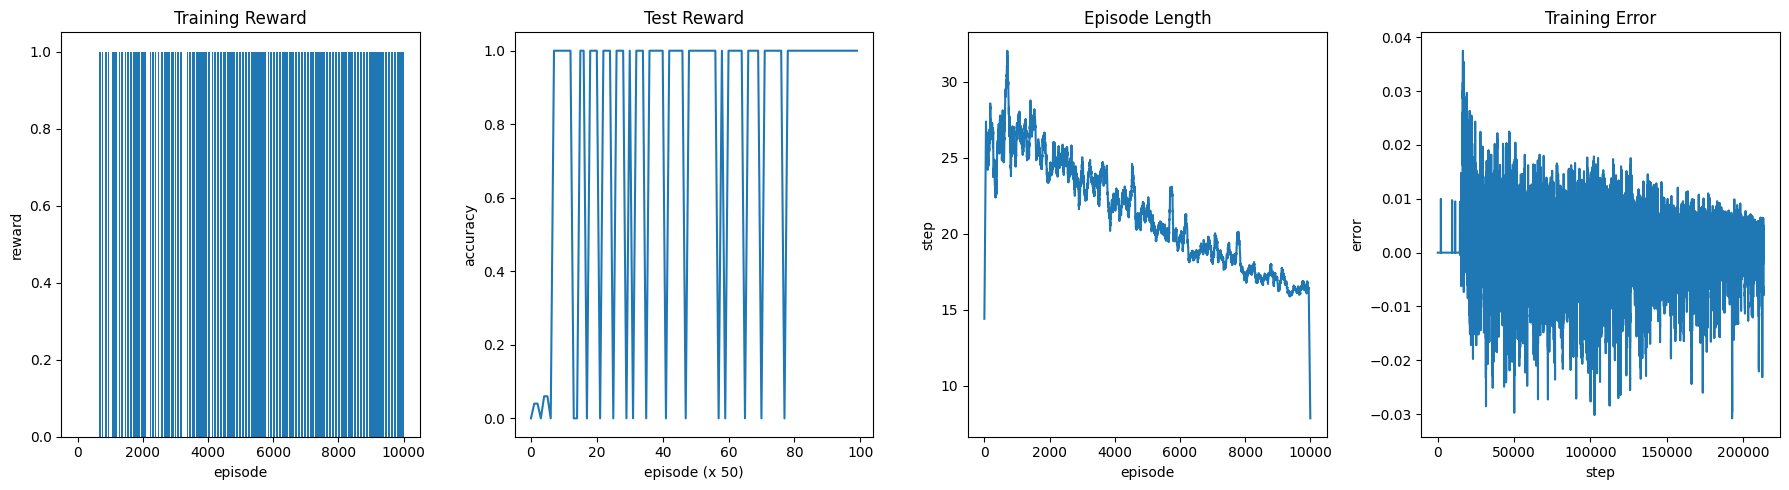

In [19]:
rolling_length = 100
fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
axs[0].set_title("Training Reward")
axs[0].set_xlabel('episode')
axs[0].set_ylabel('reward')
axs[0].bar(range(len(rewards_sarsa)), rewards_sarsa)

axs[1].set_title("Test Reward")
axs[1].set_xlabel('episode (x 50)')
axs[1].set_ylabel('accuracy')
axs[1].plot(range(len(accuracies_sarsa)), accuracies_sarsa)

axs[2].set_title("Episode Length")
axs[2].set_xlabel('episode')
axs[2].set_ylabel('step')
steps_moving_average = np.convolve(np.array(steps_sarsa), np.ones(rolling_length), mode="same") / rolling_length
axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

axs[3].set_title("Training Error")
axs[3].set_xlabel('step')
axs[3].set_ylabel('error')
training_error_moving_average = np.convolve(np.array(agent_sarsa.training_error), np.ones(rolling_length), mode="same") / rolling_length
axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()

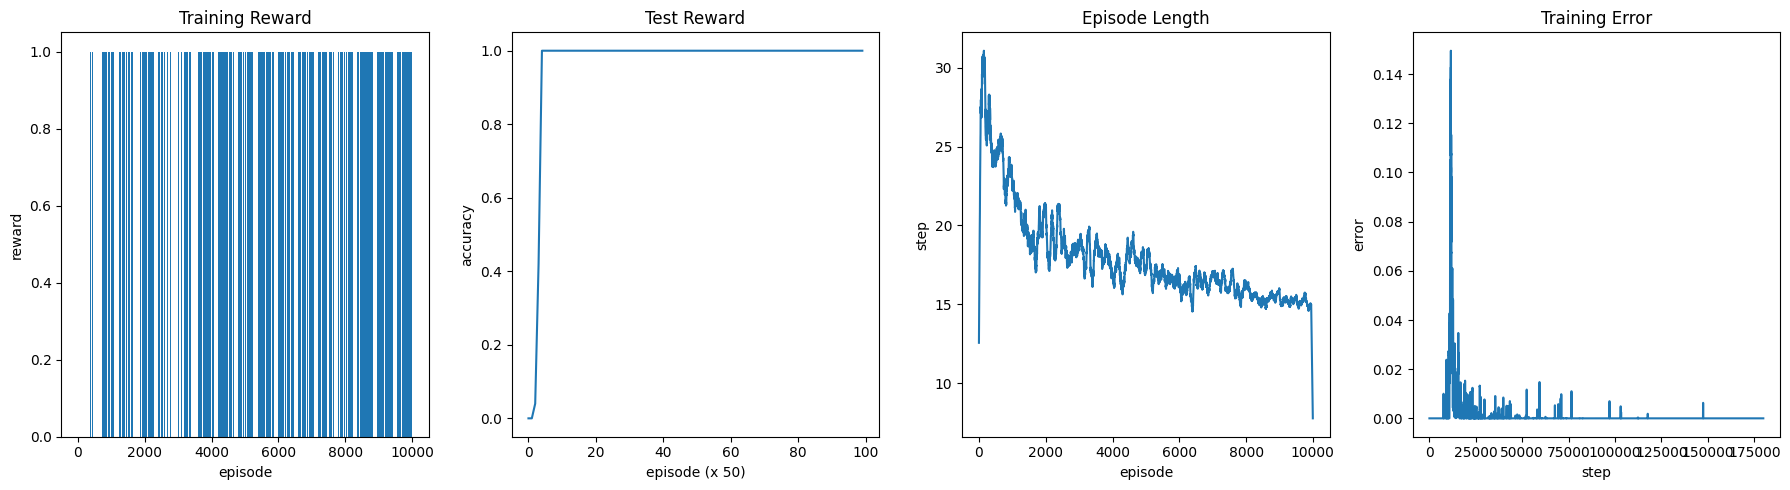

In [20]:
rolling_length = 100
fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
axs[0].set_title("Training Reward")
axs[0].set_xlabel('episode')
axs[0].set_ylabel('reward')
axs[0].bar(range(len(rewards_q)), rewards_q)

axs[1].set_title("Test Reward")
axs[1].set_xlabel('episode (x 50)')
axs[1].set_ylabel('accuracy')
axs[1].plot(range(len(accuracies_q)), accuracies_q)

axs[2].set_title("Episode Length")
axs[2].set_xlabel('episode')
axs[2].set_ylabel('step')
steps_moving_average = np.convolve(np.array(steps_q), np.ones(rolling_length), mode="same") / rolling_length
axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

axs[3].set_title("Training Error")
axs[3].set_xlabel('step')
axs[3].set_ylabel('error')
training_error_moving_average = np.convolve(np.array(agent_q.training_error), np.ones(rolling_length), mode="same") / rolling_length
axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()

In [21]:
def qtable_directions_map(qtable, map_size):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

def plot_q_values_map(qtable, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    plt.show()

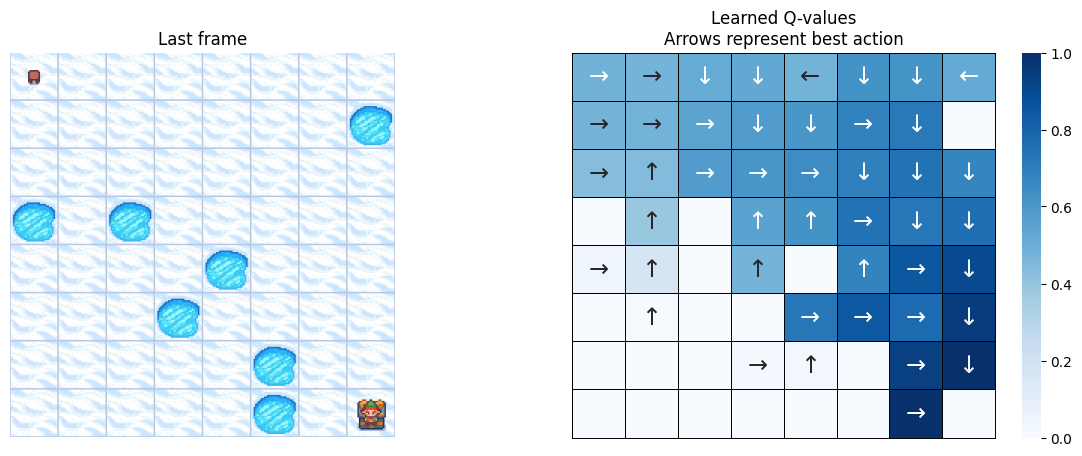

In [22]:
plot_q_values_map(agent_sarsa.get_Q_Table(), env, side_map_size)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


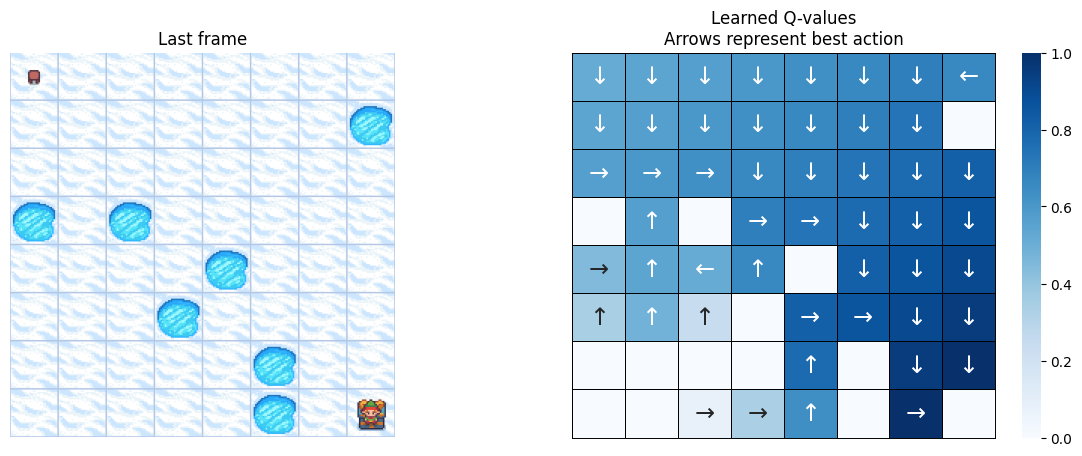

In [23]:
plot_q_values_map(agent_q.get_Q_Table(), env, side_map_size)

### Criando uma estratégia baseada em redes neurais PyTorch

In [24]:
# Importing PyTorch neural network (torch.nn) and optimizer (torch.optim)
import torch
import torch.nn as nn
import torch.optim as optim

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
env

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<TimeLimit<OrderEnforcing<PassiveEnvChecker<FrozenLakeEnv<FrozenLake-v1>>>>>

In [26]:
class LinearNetwork(nn.Module):
    """
    Linear neural network for Q-learning and SARSA
    """
    def __init__(self, state_size, hidden_size, action_size):
        super(LinearNetwork, self).__init__()
        self.input_layer = nn.Linear(state_size, hidden_size)
        self.hidden_layer = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, action_size)

        print("Artificial neural network started with PyTorch")
        print("input =", state_size, ", Hidden =", hidden_size, ", output =", action_size)

    def forward(self, state):
        x = self.input_layer(state)

        x = torch.sigmoid(self.hidden_layer(x))

        return self.output_layer(x)

In [27]:
from torch.nn.functional import one_hot

class QLearningAgent:

    def __init__(
        self,
        alpha_learning_rate,
        gamma_discount_factor,
        initial_epsilon,
        epsilon_decay,
        final_epsilon,
        state_space,
        hidden_size,
        action_space,
        device,
        model,
        optimizer,
        criterion,
        is_using_Sarsa
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            alpha_learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            gamma_discount_factor: The discount factor for computing the Q-value
            state_space: The state space
            action_space: The action space
            is_using_Sarsa: Sarsa or Q-learning method
        """
        self.alpha_learning_rate = alpha_learning_rate
        self.gamma_discount_factor = gamma_discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.state_space = state_space
        self.hidden_size = hidden_size
        self.action_space = action_space
        self.device = device
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.is_using_Sarsa = is_using_Sarsa
        self.training_error = []

        if(self.is_using_Sarsa):
            print("SARSA agent started")
        else:
            print("Q-learning agent started")

        # Set the seed
        self.rng = np.random.default_rng(123)

    def get_Q_Network(self):
        return self.model

    def get_tensor(self, value):
        return torch.tensor(value, device=self.device, dtype=torch.float32)

    def get_one_hot_tensor(self, state):
        # One-hot encode state before passing to the model
        state_tensor = torch.tensor(state, device=self.device, dtype=torch.int64)
        return one_hot(state_tensor, num_classes=self.state_space.n).type(torch.float32)

    def eval_state(self, state):
        with torch.no_grad():
            state_tensor = self.get_one_hot_tensor(state)
            q_values = self.model(state_tensor)
            return torch.argmax(q_values).item()

    def max_eval_state(self, state):
        with torch.no_grad():
            state_tensor = self.get_one_hot_tensor(state)
            q_values = self.model(state_tensor)
            return torch.max(q_values).item()

    def choose_action(self, state):
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # First we randomize a number
        exploration_exploitation_tradeoff = self.rng.uniform(0, 1)

        # Exploration
        # with probability epsilon return a random action to explore the environment
        if exploration_exploitation_tradeoff < self.epsilon:
            return self.action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            with torch.no_grad():
                return self.eval_state(state)

    def update(
        self,
        state: int,
        action: int,
        reward: float,
        terminated: bool,
        next_state: int,
        next_action: int
    ):
        """Updates the neural network weights."""
        # Train the network using target and the predicted q_network values
        # Setting the model in training mode
        self.model.train()

        if terminated:
            target = self.get_tensor(reward) # Convert reward to tensor

        else:
            # Eval next state
            next_state_tensor = self.get_one_hot_tensor(next_state) # Get one-hot encoded next state tensor

            with torch.no_grad():
                Q2 = self.model(next_state_tensor)

                # Sarsa: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * Q(s',a') - Q(s,a)]
                if(self.is_using_Sarsa):
                    target = reward + self.gamma_discount_factor * Q2[next_action].item() # Use next_action for Sarsa

                # Q-learning: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
                else:
                    target = reward + self.gamma_discount_factor * torch.max(Q2).item() # Use max Q-value for Q-learning

            target = self.get_tensor(target) # Convert target to tensor

        # Eval state
        state_tensor = self.get_one_hot_tensor(state) # Get one-hot encoded state tensor
        Q1 = self.model(state_tensor) # Get the Q-value for the chosen action

        # Computing the loss (error between the predicted Q-value and the actual Q-value)
        temporal_difference_error = self.criterion(Q1[action], target)

        self.training_error.append(temporal_difference_error.item())

        # Reset accumulated gradients
        self.optimizer.zero_grad()

        # Performing backpropagation
        temporal_difference_error.backward()

        # Updating network parameters
        self.optimizer.step()

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [28]:
# hyperparameters
alpha_learning_rate = 0.0001 # @param {type:"number"}
nb_max_episodes = 3000 # @param {type:"integer"}
start_epsilon = 0.5 # @param {type:"number"}
final_epsilon = 0.1 # @param {type:"number"}
epsilon_decay = (start_epsilon - final_epsilon) / nb_max_episodes  # reduce the exploration over time
gamma_discount_factor = 0.95 # @param {type:"number"}
is_using_Sarsa = False # @param {type:"boolean"}
test_freq = 100 # @param {type:"integer"}
total_steps = 0

# Starting the artificial neural network
# Check that there is a GPU avaiable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hidden_size = 64 # @param {type:"integer"}

# Input and output size based on the environment
# These lines establish the feed-forward part of the netwotk used to choose actions
model = LinearNetwork(env.observation_space.n, hidden_size, env.action_space.n).to(device)

# Initialize optimizer that can be SGD, Adam, RMSprop, etc.
optimizer = optim.Adam(model.parameters(), lr=alpha_learning_rate)

# Initialize loss function using mean squared error
criterion = nn.MSELoss()

agent = QLearningAgent(
    alpha_learning_rate=alpha_learning_rate,
    gamma_discount_factor=gamma_discount_factor,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    state_space = env.observation_space,
    hidden_size = hidden_size,
    action_space = env.action_space,
    device = device,
    model = model,
    optimizer = optimizer,
    criterion = criterion,
    is_using_Sarsa = is_using_Sarsa
)

Artificial neural network started with PyTorch
input = 64 , Hidden = 64 , output = 4
Q-learning agent started


In [29]:
def test_accurracy(num_steps, num_episodes=100):
    counter = 0
    nb_success = 0.0

    while counter < num_episodes:
        is_terminal = False
        state, info = env.reset()

        for i in range(num_steps):
            model.eval() # Putting the model into evaluation mode (without gradients)
            action = agent.eval_state(state)
            state, reward, terminated, truncated, info = env.step(action)
            is_terminal = terminated or truncated
            nb_success += reward

            if(is_terminal):
                break

        counter += 1

    return nb_success/counter


def record_trained_video(video_file, num_steps):
    video = VideoRecorder(env, video_file)

    # returns an initial observation
    state, info = env.reset()
    env.render()
    video.capture_frame()

    for i in range(num_steps):
        model.eval() # Putting the model into evaluation mode (without gradients)
        action = agent.eval_state(state)
        state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        env.render()
        video.capture_frame()

        if(is_terminal):
            print("step", i+1, ":", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
            break

    video.close()


In [30]:
from tqdm import tqdm
#Create lists to contain total rewards, steps and accurracy per episode
accuracies = []
mean_rewards = []
rewards = []
steps = []

for episode_count in tqdm(range(nb_max_episodes)):
    state, info = env.reset()
    is_terminal = False
    total_reward = 0
    episode_step = 0

    if(is_using_Sarsa): # Sarsa
        # Choose an action by greedily (with epsilon chance of random action) from the Q-Network
        action = agent.choose_action(state)

    # The Q-Network training
    while not is_terminal:
        episode_step += 1

        if(not is_using_Sarsa): # Q-learning
            # Choose an action by greedily (with epsilon chance of random action) from the Q-Network
            action = agent.choose_action(state)

        # Play best or random move and get new state and reward from environment
        next_state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        # update the agent
        if(not is_using_Sarsa): # Q-learning
            agent.update(state, action, reward, terminated, next_state, None)
        else: # Sarsa
            next_action = agent.choose_action(next_state)
            agent.update(state, action, reward, terminated, next_state, next_action)
            action = next_action

        # update the current observation
        state = next_state
        total_steps += 1
        total_reward += reward

    agent.decay_epsilon()

    mean_rewards.append(total_reward)
    if (episode_count+1) % test_freq == 0:
        accur = test_accurracy(env.spec.max_episode_steps,50)
        accuracies.append(accur)

        print('step: %s, episode: %s, accuracy training: %s, accuracy test: %s, random move probability: %s' % (total_steps, episode_count+1, sum(mean_rewards)/test_freq, accur, agent.epsilon))
        mean_rewards.clear()

    rewards.append(total_reward)
    steps.append(episode_step)

after_training = "after_training.mp4"
record_trained_video(after_training, env.spec.max_episode_steps)
env.close()

  3%|▎         | 101/3000 [00:12<19:17,  2.51it/s]

step: 4059, episode: 100, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.48666666666666814


  7%|▋         | 199/3000 [00:26<05:55,  7.87it/s]

step: 7339, episode: 200, accuracy training: 0.04, accuracy test: 0.0, random move probability: 0.47333333333333627


 10%|█         | 303/3000 [00:41<06:50,  6.57it/s]

step: 10713, episode: 300, accuracy training: 0.12, accuracy test: 0.0, random move probability: 0.4600000000000044


 13%|█▎        | 403/3000 [00:47<02:58, 14.54it/s]

step: 13192, episode: 400, accuracy training: 0.46, accuracy test: 1.0, random move probability: 0.44666666666667254


 17%|█▋        | 502/3000 [00:55<03:14, 12.83it/s]

step: 15981, episode: 500, accuracy training: 0.66, accuracy test: 1.0, random move probability: 0.4333333333333407


 20%|██        | 604/3000 [01:00<02:36, 15.31it/s]

step: 18391, episode: 600, accuracy training: 0.7, accuracy test: 1.0, random move probability: 0.4200000000000088


 23%|██▎       | 703/3000 [01:06<03:24, 11.23it/s]

step: 20557, episode: 700, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.40666666666667695


 27%|██▋       | 803/3000 [01:11<01:56, 18.85it/s]

step: 22764, episode: 800, accuracy training: 0.77, accuracy test: 1.0, random move probability: 0.3933333333333451


 30%|███       | 904/3000 [01:16<01:53, 18.40it/s]

step: 24855, episode: 900, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.3800000000000132


 33%|███▎      | 1003/3000 [01:21<01:59, 16.75it/s]

step: 26856, episode: 1000, accuracy training: 0.79, accuracy test: 1.0, random move probability: 0.36666666666668135


 37%|███▋      | 1103/3000 [01:25<01:28, 21.55it/s]

step: 28735, episode: 1100, accuracy training: 0.69, accuracy test: 1.0, random move probability: 0.3533333333333495


 40%|████      | 1204/3000 [01:29<01:38, 18.25it/s]

step: 30592, episode: 1200, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.3400000000000176


 43%|████▎     | 1302/3000 [01:35<01:56, 14.59it/s]

step: 32478, episode: 1300, accuracy training: 0.71, accuracy test: 1.0, random move probability: 0.32666666666668576


 47%|████▋     | 1404/3000 [01:39<01:20, 19.92it/s]

step: 34391, episode: 1400, accuracy training: 0.82, accuracy test: 1.0, random move probability: 0.3133333333333539


 50%|█████     | 1502/3000 [01:44<01:26, 17.26it/s]

step: 36362, episode: 1500, accuracy training: 0.84, accuracy test: 1.0, random move probability: 0.300000000000022


 54%|█████▎    | 1605/3000 [01:50<03:10,  7.31it/s]

step: 38235, episode: 1600, accuracy training: 0.79, accuracy test: 0.0, random move probability: 0.28666666666669016


 57%|█████▋    | 1704/3000 [01:54<01:06, 19.45it/s]

step: 40065, episode: 1700, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.2733333333333583


 60%|██████    | 1804/3000 [01:58<01:00, 19.93it/s]

step: 41876, episode: 1800, accuracy training: 0.93, accuracy test: 1.0, random move probability: 0.26000000000002643


 63%|██████▎   | 1903/3000 [02:03<00:51, 21.30it/s]

step: 43631, episode: 1900, accuracy training: 0.86, accuracy test: 1.0, random move probability: 0.24666666666669387


 67%|██████▋   | 2005/3000 [02:07<00:45, 21.72it/s]

step: 45344, episode: 2000, accuracy training: 0.78, accuracy test: 1.0, random move probability: 0.23333333333335923


 70%|███████   | 2105/3000 [02:11<00:39, 22.61it/s]

step: 47017, episode: 2100, accuracy training: 0.87, accuracy test: 1.0, random move probability: 0.2200000000000246


 73%|███████▎  | 2203/3000 [02:15<00:53, 14.77it/s]

step: 48621, episode: 2200, accuracy training: 0.88, accuracy test: 1.0, random move probability: 0.20666666666668995


 77%|███████▋  | 2304/3000 [02:20<00:36, 19.18it/s]

step: 50323, episode: 2300, accuracy training: 0.92, accuracy test: 1.0, random move probability: 0.1933333333333553


 80%|████████  | 2406/3000 [02:23<00:25, 23.61it/s]

step: 51972, episode: 2400, accuracy training: 0.83, accuracy test: 1.0, random move probability: 0.18000000000002067


 83%|████████▎ | 2504/3000 [02:27<00:24, 20.04it/s]

step: 53575, episode: 2500, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.16666666666668603


 87%|████████▋ | 2605/3000 [02:31<00:18, 21.49it/s]

step: 55120, episode: 2600, accuracy training: 0.9, accuracy test: 1.0, random move probability: 0.1533333333333514


 90%|█████████ | 2703/3000 [02:35<00:13, 22.08it/s]

step: 56736, episode: 2700, accuracy training: 0.91, accuracy test: 1.0, random move probability: 0.14000000000001675


 94%|█████████▎| 2806/3000 [02:38<00:08, 24.03it/s]

step: 58263, episode: 2800, accuracy training: 0.94, accuracy test: 1.0, random move probability: 0.1266666666666821


 97%|█████████▋| 2905/3000 [02:42<00:05, 17.35it/s]

step: 59810, episode: 2900, accuracy training: 0.98, accuracy test: 1.0, random move probability: 0.11333333333334869


100%|██████████| 3000/3000 [02:46<00:00, 18.02it/s]

step: 61364, episode: 3000, accuracy training: 0.99, accuracy test: 1.0, random move probability: 0.10000000000001544



/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


step 14 : move down , 63 , 1.0 , True , False , {'prob': 1.0}


In [38]:
html = render_mp4(after_training)
HTML(html)

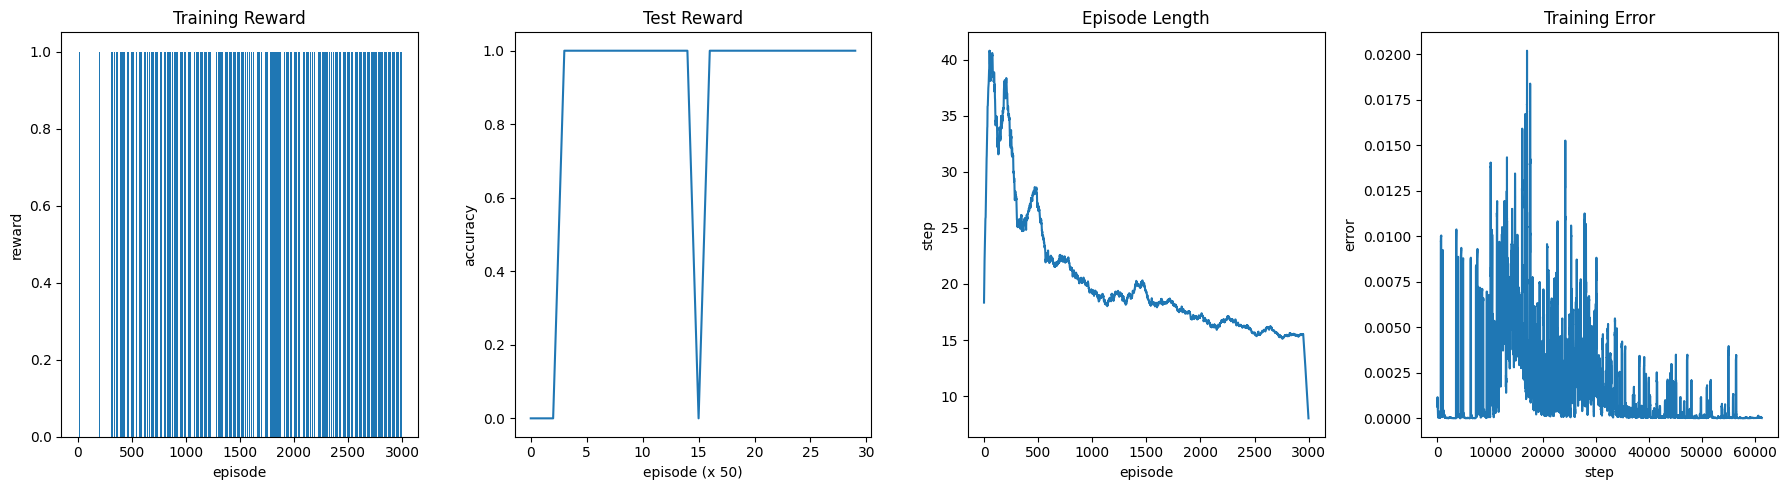

In [34]:
rolling_length = 100
fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
axs[0].set_title("Training Reward")
axs[0].set_xlabel('episode')
axs[0].set_ylabel('reward')
axs[0].bar(range(len(rewards)), rewards)

axs[1].set_title("Test Reward")
axs[1].set_xlabel('episode (x 50)')
axs[1].set_ylabel('accuracy')
axs[1].plot(range(len(accuracies)), accuracies)

axs[2].set_title("Episode Length")
axs[2].set_xlabel('episode')
axs[2].set_ylabel('step')
steps_moving_average = np.convolve(np.array(steps), np.ones(rolling_length), mode="same") / rolling_length
axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

axs[3].set_title("Training Error")
axs[3].set_xlabel('step')
axs[3].set_ylabel('error')
training_error_moving_average = np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same") / rolling_length
axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()

In [35]:
def qtable_directions_map(qtable_val_max, qtable_best_action, map_size):
    """Get the best learned action & map it to arrows."""
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    for idx, val in enumerate(qtable_best_action.flatten()):
        qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

In [36]:
def plot_q_values_map(qtable_val_max, qtable_best_action, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable_val_max, qtable_best_action, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    plt.show()

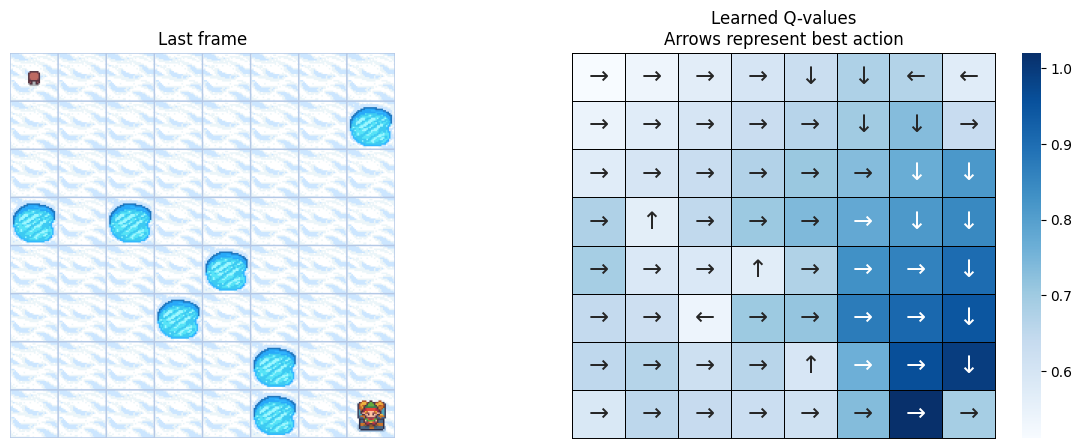

In [37]:
qtable_val_max = np.zeros((side_map_size, side_map_size))
qtable_best_action = np.zeros((side_map_size, side_map_size))
q_network = agent.get_Q_Network()

counter = 0
while counter < side_map_size * side_map_size:
    qtable_val_max[int(counter / side_map_size)][counter % side_map_size] = agent.max_eval_state(counter)
    qtable_best_action[int(counter / side_map_size)][counter % side_map_size] = agent.eval_state(counter)
    counter = counter + 1

plot_q_values_map(qtable_val_max, qtable_best_action, env, side_map_size)